<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/06-common-design-building-blocks/01_better_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Better activation functions

We will discuss five new methods that work for feed-forward models and
one new improvement to RNNs. We introduce the first five methods roughly in the
order that they were invented, as each tends to use the preceding techniques in their
design. 

Individually, they improve accuracy and speed up training; but combined, they
are greater than the sum of their parts.

1. Better activation function
2. Batch/Layer normalization
3. Skip connections and 1 x 1 convolution
4. Residual connections
5. Long short-term memory (LSTM) layer

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, weight_reset, set_seed
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
B = 128

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Baseline model

Let’s define some basic hyperparameters.

In [7]:
W, H = 28, 28
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
n_filters = 32    # filters per convolutional layer
classes = 10      # How many classes are there?

In [9]:
fc_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.Tanh(), #First hidden layer 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.Tanh()) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [10]:
cnn_model = nn.Sequential(
  nn.Conv2d(C, n_filters, 3, padding=1),             
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.MaxPool2d((2,2)),
  
  nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.MaxPool2d((2,2)),

  nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We use our new train_network function to train all of the models.

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
cnn_results = train_network(cnn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [13]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,9.792882,0.633577,0.461121,0.766650,0.837750
1,1,17.618771,0.434101,0.413325,0.845150,0.849067
2,2,25.356204,0.391224,0.358891,0.857450,0.867400
3,3,32.837183,0.363648,0.327916,0.868283,0.877617
4,4,42.854742,0.346689,0.332774,0.873750,0.883317


In [14]:
cnn_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,19.877316,0.491520,0.315718,0.82165,0.885933
1,1,32.926881,0.320271,0.300401,0.88580,0.892483
2,2,45.907234,0.283402,0.227856,0.90060,0.918867
3,3,60.507609,0.256085,0.238842,0.90905,0.912200
4,4,74.991117,0.246041,0.245748,0.91435,0.917450


Let’s be explicit and tell Python we are finished so we can get back the GPU memory.

In [15]:
del fc_model
del cnn_model

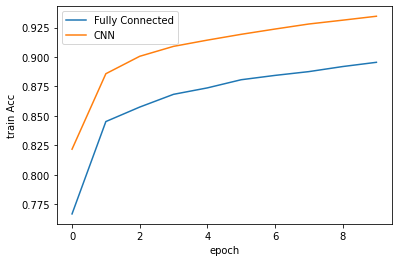

In [16]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

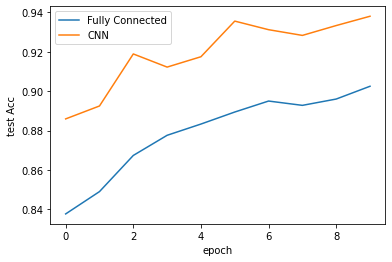

In [17]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")

##Vanishing gradients